In [2]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [ ]:
from razor import Block, inputs, outputs, Pipeline
from razor.api import project_space_path
import razor
from razor import Technology, LibraryMode
from razor.core.blocks import ContainerExecutor


In [18]:
## Simple "Memory profilers" to see memory usage
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [19]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [20]:
## Merging by concat to not lose dtypes
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1

In [21]:
########################### Vars
#################################################################################
TARGET = 'sales'         # Our main target
END_TRAIN = 1913         # Last day in train set
MAIN_INDEX = ['id','d']  # We can identify item by these columns

In [22]:
########################### Load Data
#################################################################################
print('Load Main Data')

# Here are reafing all our data 
# without any limitations and dtype modification
train_df = pd.read_csv(project_space_path("M5Forecasting/sales_train_validation.csv"))
prices_df = pd.read_csv(project_space_path("M5Forecasting/sell_prices.csv"))
calendar_df = pd.read_csv(project_space_path("M5Forecasting/calendar.csv"))


Load Main Data


In [ ]:
train_df = reduce_mem_usage(train_df)
prices_df = reduce_mem_usage(prices_df)
calendar_df = reduce_mem_usage(calendar_df)


In [23]:
train_df.shape

(30490, 1919)

In [1]:
razor.api.engines("DS-engine").health()

PlatformEngineHealthList(slave_usage_array=[PlatformEngineHealth(server_ip='172.16.104.139', server_type='INFRASTRUCTURE', server_usage_info=[ServerUsageInfo(label='Current cpu usage', graph_type='bar', unit='', total=16, used=3, available=13, value='CORE'), ServerUsageInfo(label='Current memory usage', graph_type='bar', unit='GB', total=40802189312.0, used=3221225472.0, available=37580963840.0, value='RAM'), ServerUsageInfo(label='Current gpu usage', graph_type='bar', unit='', total=0, used=0, available=0, value='GPU')]), PlatformEngineHealth(server_ip='172.16.114.99', server_type='TECHNOLOGY', server_usage_info=[ServerUsageInfo(label='Current cpu usage', graph_type='bar', unit='', total=32, used=1, available=31, value='CORE'), ServerUsageInfo(label='Current memory usage', graph_type='bar', unit='GB', total=123480309760.0, used=4294967296.0, available=119185342464.0, value='RAM'), ServerUsageInfo(label='Current gpu usage', graph_type='bar', unit='', total=0, used=0, available=0, value='GPU')])])

In [24]:
train_df.to_csv(project_space_path('train_df.csv'), index=False)

In [10]:
project_space_path('train_df.csv')

'/home/jovyan/project-space/train_df.csv'

In [4]:
@inputs.atomic.string('path')
class Melter(Block):
    def run(self, path):
        import logging
        from razor.api import project_space_path
        import pandas as pd
        
        TARGET = 'sales'
        df = pd.read_csv(project_space_path(path))
        logging.info('Create Grid')
        index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
        grid_df = pd.melt(df, 
                          id_vars = index_columns, 
                          var_name = 'd', 
                          value_name = TARGET)
        
        logging.info(grid_df.head())
        grid_df.to_csv(project_space_path('melted_df.csv'), index=False)
        
        

In [5]:
melter = (
    Melter()
    .path('train_df.csv')  # (series, string)
    .executor(ContainerExecutor(cores=2, memory=8192))
)

In [6]:
p = Pipeline("Melting", targets=[melter], env=Technology.PYTHON)  #preprocess


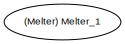

In [7]:
p.show()

In [8]:
deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [9]:
deployed_pipeline

PlatformPipelineRun(project_id='c0b26d85-a4c9-44f5-9d0e-f540dd2de644', pipeline_id='d18dd812-d0b2-11ea-bc5a-55ff63d3667a', pipeline_name='Melting', pipeline_run_id='e5de69cb-a742-4f15-a17e-4492e34fed52', pipeline_version=None, comment=None, created_on='2020-07-28T09:15:07.800+0000', start_time=None, end_time=None, eta=0, run_at=1595927707800, run_duration=0, compute_time=0, wait_time=0, ran_by_user=RanByUser(user_name='Ayan Basak', email='ayan.basak@razorthink.com'), status='IN_PROGRESS', block_status=[PlatformPipelineBlockRun(pipeline_run_id='e5de69cb-a742-4f15-a17e-4492e34fed52', pipeline_name='Melting', pipeline_status='IN_PROGRESS', block_id='390773c5-a83c-44ef-a0e6-c247287fb8ef', block_run_id='83a6cd71-cfb5-4f04-a138-e1a1cfeca511', block_name='Melter_1', resource_spec=ResourceAllocated(cores=2, memory=8192, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'), technology='PYTHON', wait_time=0, compute_time=0, status='YET_TO_START', containers=[], cluster_id='390773c5-a83c-44ef-a0e6-c247287fb8ef', _log=None, _metric=None)], run_number=8, pipeline_variable_list=[], block_run_details=[BlockRunDetail(block_id='390773c5-a83c-44ef-a0e6-c247287fb8ef', block_run_id='83a6cd71-cfb5-4f04-a138-e1a1cfeca511', block_name='Melter_1', technology='PYTHON', log_path=None, input_parameters='{\n  "path": {\n    "dtype": "string",\n    "required": "false",\n    "series": false,\n    "adapter": "eJxrYJlqzAABPRJFiVX5RXrJ+UWpekk5+cnZxXqZeQWlJcVTeoScQHxPEE8vMSWxoCS1aMrkKXoAUvYVmA==",\n    "validator": "eJxrYJnqyAABPRJFiVX5RXrJ+UWpekk5+cnZxXqZeQWlJcVTehQcS/JzM5OdQKLBJUWZeemeIBm9ssSczJTEkvyiKZOn6AEArzAbbQ==",\n    "source_id": null,\n    "source_name": null,\n    "inferred_type": "STATIC",\n    "value": "eJxrYJkqwAABPTwlRYmZefEpaXrJxWVT9ABRyQdF"\n  }\n}', output_parameters=None, status='YET_TO_START', created_at=None, start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[], resource_allocated=ResourceAllocated(cores=2, memory=8192, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'))], pipeline_json='{\n  "id": "d18dd812-d0b2-11ea-bc5a-55ff63d3667a",\n  "projectId": "c0b26d85-a4c9-44f5-9d0e-f540dd2de644",\n  "name": "Melting",\n  "description": "",\n  "blocks": [\n    {\n      "name": "Melter_1",\n      "id": "390773c5-a83c-44ef-a0e6-c247287fb8ef",\n      "artifact_id": null,\n      "class_name": "Melter",\n      "code": "eJxtU0tvGzcQXq72ZTlWiiKPtofCR+dgIXFkRwGaAqlQBK1QHRy3t4KgdrjatajlZsl14mJVFAiCIABzKnu3/0n/WTtcKUgOWQGaIefBeXzfX8E//wZe95m7qZANVEW6FHz4iW7N17Tm+SXUTHOqllxwLUuaCqaU/dse5J65RVds+TmbSeZNIXRRKmsCfVlxvDTRL1xoXlvzVc3+kPUwlTUfzoVMl2orrAl/cAp6v7Fra2JKQaaU2pky+/dHDx+PxvxkPErvj4DxMYP5iJ2MHxxlR4/hKLMzbU8x6sD0KV1JaATHSJPggRWlU3t1U1ose0CzQgiaNWWqC1lum7n5sZnOhNd4u0e3ndAPbSQTCfzMHd7gewdTf+pNd6bRdDL5Ewh4wlv7KH1BVv66R7zurrcOoLcO2+AqaHsteU2uyTpq/asQgmuCPiFEEEMCO9BfROu4Dc6jNmpj2G1DuPE+WCfOt02u4mvP+bfJedL2YO81gQHcfO9jBu+5Zw9mU898WdXynKeaqoqlnFZM51ioCRUTHAe8O6k57nP/WV2ANb77iwvNV7TTgFe606KUbZREaVzTB9UhwamkCwN6wWrMmaCgJVshZPoXTDR8c3hrzd7KrRwoZMNUXdh3JixK4K+wII17ioVcLIpyYc3OBhGsKmy+b6KKlcBcYqwVqIs0QVFmEoVLiCJHA1apZWd1yQLFRYaWruH8IabxK+dy9vT02Y9n2Cqgda97nqZSNCuHzXiBY8DqMIP59ruiutS5LA+Lsmr04ejwUQaj45NHx+Oj8fH3Nr897U2+8UhCbpDED8iA9MkXJCI+/hJ/QOy9ew6AP/+Hn0PhLsXhp0u2cDCcORy6qaCe32rebpEaL4ScM6Ec2BPgGWuEVugcQJFqdzlAQqoGF9DN1ZmiDbQxiwm6Mee3TQ9Zgqa79BP6UtXMN67K/o57Z2UpcX+I981rLxomtjvb8HLo2GH6y5cf62j0KdKiG4eiW4nB+ROsPf81f2JC6FjxOUZvvc2dp1quirTj9XNd47p/chbHpFCwORd2lv82c9DrXrXG6/b+oilqDvZdo8wd2gW7AhCBJYI6lU2p7ZRgfcP/AZ3Iwt0=",\n      "isPublishedBlock": false,\n      "source": null,\n      "inputProperty": {\n        "path": {\n          "dtype": "string",\n          "required": "false",\n          "series": false,\n          "adapter": "eJxrYJlqzAABPRJFiVX5RXrJ+UWpekk5+cnZxXqZeQWlJcVTeoScQHxPEE8vMSWxoCS1aMrkKXoAUvYVmA==",\n          "validator": "eJxrYJnqyAABPRJFiVX5RXrJ+UWpekk5+cnZxXqZeQWlJcVTehQcS/JzM5OdQKLBJUWZeemeIBm9ssSczJTEkvyiKZOn6

In [10]:
deployed_pipeline.logs()

PlatformPipelineRunLogs(pipeline_name='Melting', engine_logs=[], block_logs=[PlatformPipelineBlockRunLogs(pipeline_id='d18dd812-d0b2-11ea-bc5a-55ff63d3667a', pipeline_run_id='e5de69cb-a742-4f15-a17e-4492e34fed52', block_id='390773c5-a83c-44ef-a0e6-c247287fb8ef', block_run_id='83a6cd71-cfb5-4f04-a138-e1a1cfeca511', logs=[PlatformPipelineBlockRunLog(log_level='DEBUG', log_type='Block', timestamp='2020-07-28 09:15:15.766', message='Block is ready to run 140109229309296', pipeline_id='d18dd812-d0b2-11ea-bc5a-55ff63d3667a', pipeline_run_id='e5de69cb-a742-4f15-a17e-4492e34fed52', block_id='390773c5-a83c-44ef-a0e6-c247287fb8ef', block_run_id='83a6cd71-cfb5-4f04-a138-e1a1cfeca511', pipeline_name='Melting', block_name='Melter_1'), PlatformPipelineBlockRunLog(log_level='INFO', log_type='Block', timestamp='2020-07-28 09:15:19.627', message='Setting block parameters', pipeline_id='d18dd812-d0b2-11ea-bc5a-55ff63d3667a', pipeline_run_id='e5de69cb-a742-4f15-a17e-4492e34fed52', block_id='390773c5-a83c-44ef-a0e6-c247287fb8ef', block_run_id='83a6cd71-cfb5-4f04-a138-e1a1cfeca511', pipeline_name='Melting', block_name='Melter_1'), PlatformPipelineBlockRunLog(log_level='DEBUG', log_type='Block', timestamp='2020-07-28 09:15:19.633', message='Output status of block(83a6cd71-cfb5-4f04-a138-e1a1cfeca511) for output_dent(None) is: COMPLETED and Output: None', pipeline_id='d18dd812-d0b2-11ea-bc5a-55ff63d3667a', pipeline_run_id='e5de69cb-a742-4f15-a17e-4492e34fed52', block_id='390773c5-a83c-44ef-a0e6-c247287fb8ef', block_run_id='83a6cd71-cfb5-4f04-a138-e1a1cfeca511', pipeline_name='Melting', block_name='Melter_1')], pipeline_name='Melting', block_name='Melter_1')])

In [19]:
print('Create Grid')

# We can tranform horizontal representation 
# to vertical "view"
# Our "index" will be 'id','item_id','dept_id','cat_id','store_id','state_id'
# and labels are 'd_' coulmns

index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
grid_df = pd.melt(train_df.iloc[:100, :], 
                  id_vars = index_columns, 
                  var_name = 'd', 
                  value_name = TARGET)

# If we look on train_df we se that 
# we don't have a lot of traning rows
# but each day can provide more train data
print('Train rows:', len(train_df), len(grid_df))


Create Grid
Train rows: 30490 191300


In [ ]:
# To be able to make predictions
# we need to add "test set" to our grid
add_grid = pd.DataFrame()
for i in range(1,29):
    temp_df = train_df[index_columns]
    temp_df = temp_df.drop_duplicates()
    temp_df['d'] = 'd_'+ str(END_TRAIN+i)
    temp_df[TARGET] = np.nan
    add_grid = pd.concat([add_grid,temp_df])

grid_df = pd.concat([grid_df,add_grid])
grid_df = grid_df.reset_index(drop=True)

# Remove some temoprary DFs
del temp_df, add_grid

# We will not need original train_df
# anymore and can remove it
del train_df

# You don't have to use df = df construction
# you can use inplace=True instead.
# like this
# grid_df.reset_index(drop=True, inplace=True)

# Let's check our memory usage
print("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

# We can free some memory 
# by converting "strings" to categorical
# it will not affect merging and 
# we will not lose any valuable data
for col in index_columns:
    grid_df[col] = grid_df[col].astype('category')

# Let's check again memory usage
print("{:>20}: {:>8}".format('Reduced grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

Create Grid
